In [2]:
# from google.colab import drive
# drive.mount("/gdrive", force_remount=True)

In [5]:
import pandas as pd
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

from tqdm.autonotebook import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
# import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

import typing as tp
import faiss
from sklearn.metrics.pairwise import euclidean_distances
from functools import partial
import shutil
import random

np.random.seed(31337)

## Нейросетевой отборщик кандидатов
* Нужен, чтобы быстро найти кандидатов для юзера
* Обучается с помощью лосса, который учитывает близость эмбеддингов, а не скоры

#### Проблема:
Допустим, мы обучаем модель, которая ранжирует кандидатов. Отскорить всех кандидатов в real-time мы сможем за O(N). Это не подходит, если кандидатов очень много. Поэтому будем использовать приближенный поиск соседей (LSH, FAISS etc). При этом соседей мы будем находить по расстоянию между вектором юзера и векторами кандиадтов.

### Решение:
Давайте обучим отдельную модель -- отборщика кандидатов -- которая будет качественно искать ближайших соседей. Для этого смоделируем релевантность с помощью любой метрики, отражающей близость векторов.



In [2]:
import glob

In [3]:
DATA_DIR = "/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/"

In [6]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/data_10k/*/data.json")
])
data["rnd"] = np.random.random(len(data))

track_metadata = pd.read_json("../botify/data/tracks.json", lines=True).drop_duplicates(subset=["track"])

In [7]:
data

# NCF

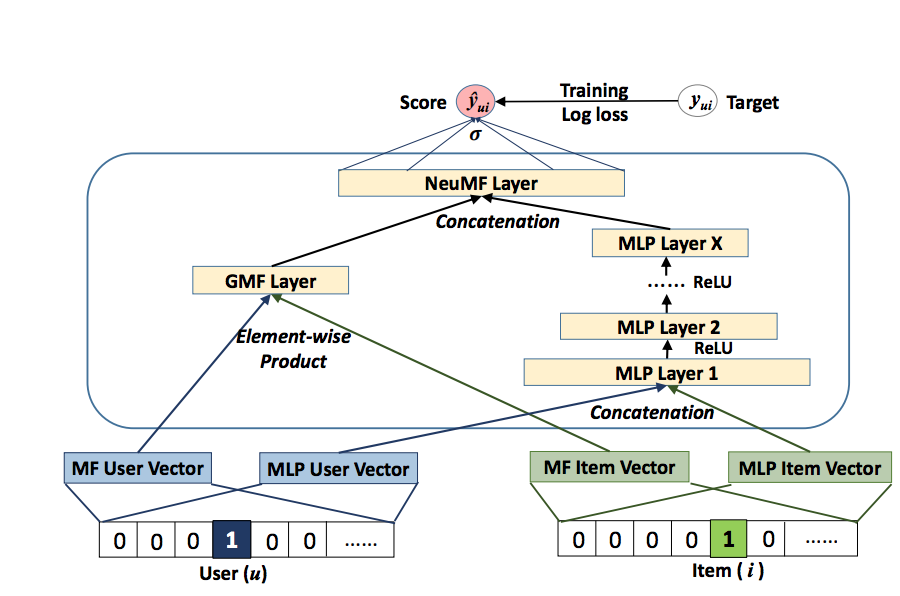

## Конфигурим датку для обучения сеточки

In [10]:
class Rating_Datset(torch.utils.data.Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

In [291]:
class NCF_Data(object):
    """
    Construct Dataset for NCF
    """
    def __init__(self, ratings, num_ng, num_ng_test, batch_size, seed):
        self.ratings = ratings
        self.num_ng = num_ng
        self.num_ng_test = num_ng_test
        self.batch_size = batch_size
    
        self.preprocess_ratings = self._reindex(self.ratings)
    
        self.user_pool = set(self.ratings['user_id'].unique())
        self.item_pool = set(self.ratings['item_id'].unique())
    
        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        # self.negatives = self._negative_sampling(self.preprocess_ratings)
        random.seed(seed)
    
    def _reindex(self, ratings):
        user_list = list(ratings['user'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}
        self.user2id = user2id
        self.id2user = {v:k for k, v in self.user2id.items()}
        
        item_list = list(ratings['track'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}
        self.item2id = item2id
        self.id2item = {v:k for k, v in self.item2id.items()}
        
        ratings['user_id'] = ratings['user'].apply(lambda x: user2id[x])
        ratings['item_id'] = ratings['track'].apply(lambda x: item2id[x])
        ratings['rating'] = ratings['time'].apply(lambda x: float(x > 0.8))
        rating_pos = ratings.loc[ratings['rating'] == 1.0]
        return rating_pos.copy(deep=True)
    
    def _leave_one_out(self, ratings):
        ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]
        assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
        return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]
    
    
    # def _negative_sampling(self, ratings):
    #     interact_status = (
    #         ratings.groupby('user_id')['item_id']
    #         .apply(set)
    #         .reset_index()
    #         .rename(columns={'item_id': 'interacted_items'}))
    #     interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
    #     interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
    #     return interact_status[['user_id', 'negative_items', 'negative_samples']]
    
    def get_train_instance(self):
        users, items, ratings = [], [], []
        # train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
        negatives = np.random.choice(range(50000), size=(len(self.train_ratings), self.num_ng))
        # train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
        self.train_ratings['negatives'] = negatives.tolist()
        for row in self.train_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in range(self.num_ng):
                users.append(int(row.user_id))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def get_test_instance(self):
        users, items, ratings = [], [], []
        # test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
        negatives = np.random.choice(range(50000), size=(len(self.test_ratings), self.num_ng_test))
        self.test_ratings['negative_samples'] = negatives.tolist()
        for row in self.test_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in getattr(row, 'negative_samples'):
                users.append(int(row.user_id))
                items.append(int(i))
                ratings.append(float(0))
        dataset = Rating_Datset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=0)

In [292]:
NUM_NG = 4
NUM_NG_TEST = 10
BATCH_SIZE = 256
SEED = 42

In [293]:
%%time
ncf_data = NCF_Data(ratings=data, num_ng=NUM_NG, num_ng_test=NUM_NG_TEST, batch_size=BATCH_SIZE, seed=SEED)

In [88]:
%%time
ncf_train_loader = ncf_data.get_train_instance()

In [317]:
ncf_train_loader

In [89]:
%%time
ncf_test_loader =ncf_data.get_test_instance()

In [318]:
ncf_test_loader

## Конфигурим модель NCF

In [90]:
class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = args.factor_num
        self.factor_num_mlp =  int(args.layers[0]/2)
        self.layers = args.layers
        self.dropout = args.dropout

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(args.layers[:-1], args.layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        self.affine_output = nn.Linear(in_features=args.layers[-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)

        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        nn.init.xavier_uniform_(self.affine_output.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

In [91]:
from dataclasses import dataclass
from typing import List

In [320]:
from datetime import datetime

In [159]:
@dataclass
class ModelConfig:
    """Класс для хранения параметров модели NCF"""
    seed: int = 42
    lr: float = 0.001
    dropout: float = 0.2
    batch_size: int = 256
    epochs: int = 10
    top_k: int = 10
    factor_num: int = 32
    layers: List[int] = (64, 32, 16, 8)
    num_ng: int = 4
    num_ng_test: int = 10
    out: bool = True

    def __post_init__(self):
        # Для преобразования кортежа в список при инициализации
        if isinstance(self.layers, tuple):
            self.layers = list(self.layers)

In [160]:
args = ModelConfig()

In [334]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [163]:
num_users = ncf_data.preprocess_ratings['user_id'].nunique()
num_items = 50000

In [336]:
import torch.optim as optim

In [165]:
model = NeuMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [166]:
import time

In [167]:
from tensorboardX import SummaryWriter

In [168]:
writer = SummaryWriter()

In [169]:
def get_val_loss(model, test_loader, device):

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
    
        predictions = model(user, item)
        loss = loss_function(predictions, label)

    return loss

In [170]:
for epoch in range(1, args.epochs+1):
    print('Epoch {}/{}'.format(epoch, args.epochs))
    model.train() # Enable dropout (if have).
    start_time = time.time()
    
    for i, (user, item, label) in enumerate(ncf_train_loader):
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
    
        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        writer.add_scalar('loss/Train_loss', loss.item(), epoch)
        if i % 1000 == 0:
            print("i: ", i)
            print("Loss: ", loss.item())
    val_loss = get_val_loss(model, ncf_test_loader, device)
    print(val_loss.item())
    writer.add_scalar('loss/Val_loss', val_loss.item(), epoch)
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
writer.close()

In [337]:
model

In [297]:
for user in data['user'].unique():
    us_id = ncf_data.user2id[user]
    pred_item_idx = torch.topk(model(torch.tensor([us_id for _ in range(50000)]), torch.tensor([i for i in range(50000)])), 100)[1]
    pred_items = [ncf_data.id2item[i] for i in pred_item_idx.numpy()]

In [314]:
with open("/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/data_10k/ncf.json", "w") as rf:
    # for user, user_emb in tqdm(zip(user_ids, user_embeddings), total=len(user_ids)):
    #   # dists, neighbours = index_flat.search(user_emb.astype('float32')[np.newaxis, :], k)
    for user in tqdm(data['user'].unique()):
        us_id = ncf_data.user2id[user]
        pred_item_idx = torch.topk(model(torch.tensor([us_id for _ in range(50000)]), torch.tensor([i for i in range(50000)])), 100)[1]
        pred_items = [ncf_data.id2item[i] for i in pred_item_idx.numpy()]
        recommendation = {
            "user": int(user),
            "tracks": pred_items
        }
        rf.write(json.dumps(recommendation) + "\n")

### DSSM:
[DSSM](https://kishorepv.github.io/DSSM/) модель "сближает" эмбеддинги юзера и позитивных айтемов и "раздвигает" эмбеддинги юзера и негативных айтемов.

#### Архитектура:
1.   **ItemModel**: FF нейросеть, которая маппит фичи айтема в латентное пространство модели
2.   **UserModel**: FF нейросеть, которая маппит фичи юзера в латентное пространство модели  
3.   **Loss**: Triplet loss

В кчаестве фичей айтемов будем использовать доступные нам фичи: популярность, жанр. В качестве фичей юзеров будем использовать multi-hot вектора из матрицы интеракций.

Если фичей айтемов и юзеров нет, то можно сделать one-hot кодирование, имея айди юзера и айтемов.


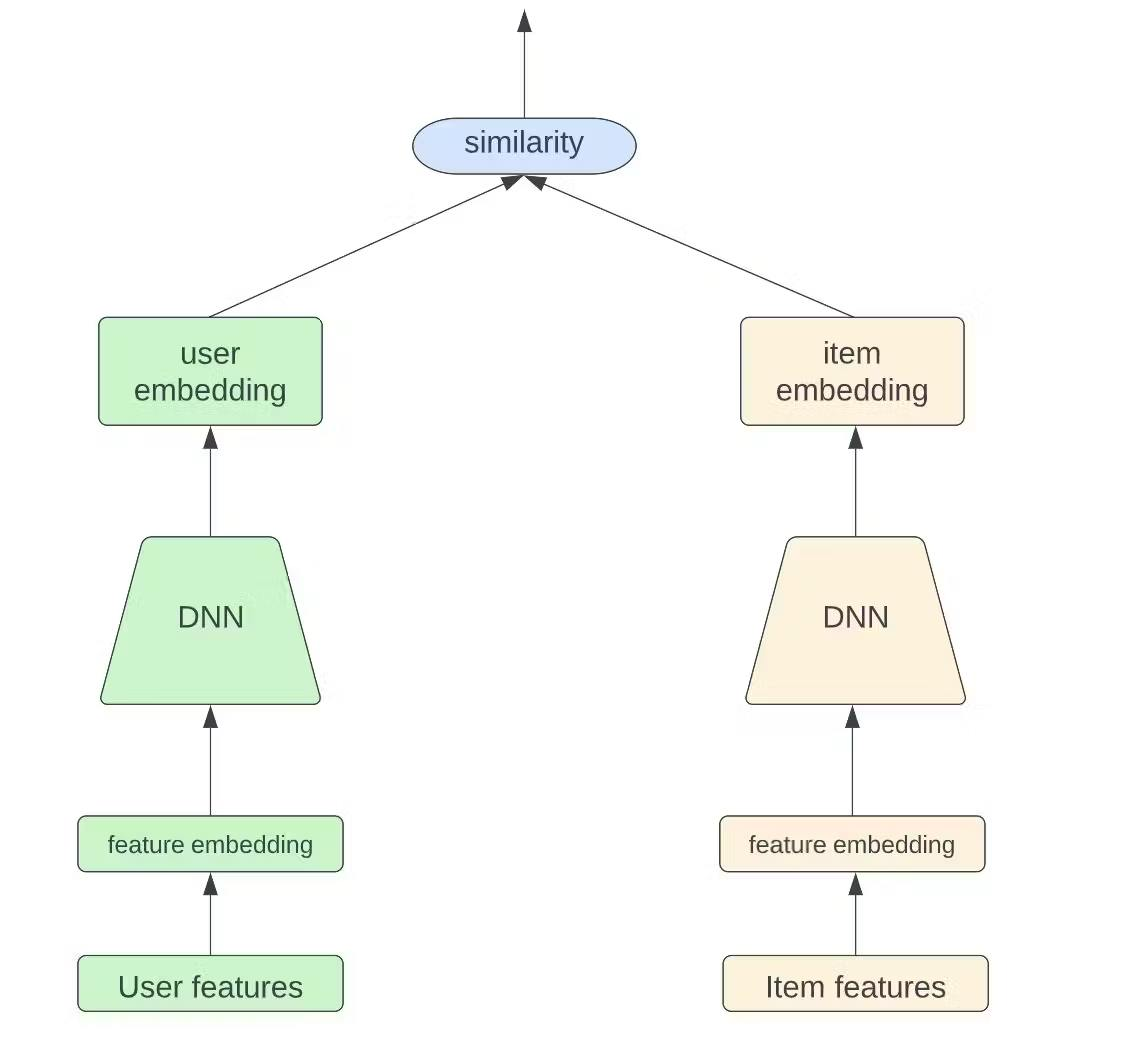

### Triplet loss

$${\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}_{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}_{2}+\alpha ,0\right)}$$

${f}(A)$ - эмбеддинг юзера,

${f}(P)$ - эмбеддинг позитивного айтема,

${f}(N)$ - эмбеддинг негативного айтема

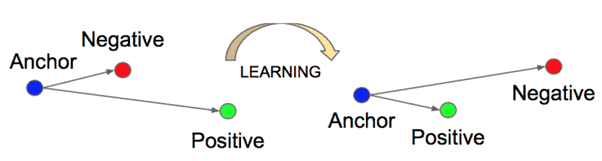

### Сбор данных
* Триплеты: юзер, позитивный айтем, негативный айтем
* Фичи юзера: матрица интеракций
* Фичи айтемов: ohe категориальные фичи

Отберем позитивные интеракции для фичей юзера

In [338]:
positives = data[data["time"] > 0.8].copy()

track_counts = positives.groupby("track").size()
tracks = set(track_counts
             [track_counts >= 5]
             .index.values)

data_filt = positives[positives["track"].isin(tracks)]

len(data_filt), len(tracks)

In [339]:
data_filt

In [250]:
interactions = pd.pivot_table(data_filt, values="time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions.shape))
print("Sparsity=" + str((interactions != 0).values.sum() / interactions.size))

In [340]:
interactions

Отберем фичи айтемов: популярность и жанр

In [343]:
track_metadata.head()

In [341]:
track_metadata.shape, track_metadata.isnull().sum(axis = 0)

In [344]:
track_metadata = track_metadata.fillna(value={'genre': 'Unk'})

In [345]:
dummy_features = pd.get_dummies(track_metadata["genre"].apply(lambda x: x[0]))

In [346]:
dummies = pd.get_dummies(track_metadata["genre"].explode()).groupby(level=0).sum()

In [347]:
item_features = pd.concat([track_metadata[["track", "pop"]], dummies], axis=1).set_index("track", drop=True)

In [348]:
item_features.head()

In [258]:
# item_features['log_pop'] = np.log(item_features['pop'])

In [349]:
# item_features = pd.concat([track_metadata[["track", "pop"]], dummy_features], axis=1).set_index("track", drop=True)
item_features.shape

Соберем трейн сразу по тройкам объектов:

uid, iid_pos, iid_neg

* pos - позитивный айтем из сессиии
* neg - случайный айтем из всего каталога

In [350]:
triplets = data_filt[["user", "track"]].rename(columns={"track": "track_pos"})

In [351]:
NUM_NEGATIVE_SAMPLES = 10
triplets =  pd.concat([triplets] * NUM_NEGATIVE_SAMPLES).sort_index().reset_index(drop=True)
triplets["track_neg"] = np.random.choice(range(50000), len(triplets))

In [352]:
triplets

Разобьем тройки на train, val, test

In [353]:
rdm = np.random.random(len(triplets))
train_data = triplets[rdm < 0.8]
val_data = triplets[(rdm >= 0.8) & (rdm < 0.9)]
test_data = triplets[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

In [354]:
item_features.shape, interactions.shape

In [355]:
from random import shuffle

def pad_with_specific_value(lst, size, val):
    lst = list(set(lst))
    shuffle(lst)
    lst = lst[:size]
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

padded_users = triplets.groupby("user").apply(lambda x: (
    pad_with_specific_value(x['track_pos'].tolist(), 30, 50000).tolist()
))

padded_users = padded_users.reindex(range(10000), fill_value=[50000] * 30)
padded_users = np.stack(padded_users.values)

In [356]:
padded_users

### Создаем датасет для оубчения

Он должен возвращать 3 тензора:

*   user_feaures
*   item_features_pos
*   item_features_neg



In [268]:
class DSSMData(pl.LightningDataModule):
  def __init__(self, train_triplets, val_triplets, test_triplets, item_features, padded_users):
      super().__init__()
      self.train_triplets = train_triplets
      self.val_triplets = val_triplets
      self.test_triplets = test_triplets
      self.item_features = item_features
      self.padded_users = padded_users

  def _collect_data(self, triplets):
      users = triplets["user"].values
      positives = triplets["track_pos"].values
      negatives = triplets["track_neg"].values

      # Wipe out positive interacted tracks from user listen history
      listened_tracks = self.padded_users[users]
      listened_tracks[listened_tracks == positives.reshape(-1, 1)] = 50000
      listened_tracks[listened_tracks == negatives.reshape(-1, 1)] = 50000

      return td.TensorDataset(
            torch.from_numpy(listened_tracks).long(),
            torch.from_numpy(item_features.loc[positives].values).double(),
            torch.from_numpy(item_features.loc[negatives].values).double()
      )

  def prepare_data(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = self._collect_data(self.train_triplets)
        self.val_dataset = self._collect_data(self.val_triplets)
      elif stage == "test" or stage is None:
        self.test_dataset = self._collect_data(self.test_triplets)

  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=2048, shuffle=False, num_workers=0)

### DSSM-модель

In [269]:
class DSSM(pl.LightningModule):
    def __init__(
        self,
        dim_item_features: int,
        item_number: int,
        embedding_dim: int = 100,
        activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu,
        lr: float = 1e-3,
        triplet_loss_margin: float = 0.4,
        weight_decay: float = 1e-6,
        log_to_prog_bar: bool = True,
    ) -> None:
        super().__init__()
        self.lr = lr
        self.triplet_loss_margin = triplet_loss_margin
        self.weight_decay = weight_decay
        self.log_to_prog_bar = log_to_prog_bar
        self.item_net = ItemNet(embedding_dim, dim_item_features, activation)
        self.user_net = UserNet(embedding_dim, item_number)

    def forward(
        self,
        user_ids: torch.Tensor,
        item_features_pos: torch.Tensor,
        item_features_neg: torch.Tensor,
    ) -> tp.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        anchor = self.user_net(user_ids)
        pos = self.item_net(item_features_pos)
        neg = self.item_net(item_features_neg)

        return anchor, pos, neg

    def _step(self, batch, batch_idx, metric, prog_bar=False):
        user_ids, pos, neg = batch
        anchor, positive, negative = self(user_ids, pos, neg)
        loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.triplet_loss_margin)
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "train_loss")

    def validation_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "val_loss", self.log_to_prog_bar)

    def test_step(self, batch, batch_idx, prog_bar=False):
        return self._step(batch, batch_idx, "test_loss", self.log_to_prog_bar)

    def inference(self, dataloader: td.DataLoader[tp.Any], mode: str = "item") -> np.ndarray:
        batches = []
        user_ids = []
        if(mode == "user"):
          model = self.user_net
        elif(mode == "item"):
          model = self.item_net
        else:
          raise ValueError(f"Unsupported model {mode}!")

        self.eval()
        for batch in dataloader:
            ids, features = batch
            with torch.no_grad():
                v_batch = model(features.to(self.device))
            batches.append(v_batch)
            user_ids.append(ids)
        vectors = torch.cat(batches, dim=0).cpu().numpy()
        vectors_ids = torch.cat(user_ids, dim=0).cpu().numpy()
        return vectors_ids, vectors

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [270]:
class ItemNet(nn.Module):
    def __init__(self, n_factors: int, dim_input: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu) -> None:
        super().__init__()
        self.embedding_layer = nn.Linear(dim_input - 1, 32, bias=False)
        self.dense_layer = nn.Linear(32 + 1, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + 32, n_factors, bias=False)
        self.activation = activation

    def forward(self, item_features: torch.Tensor) -> torch.Tensor:
        popularity = item_features[:, 0].view(-1, 1)
        genre_emb = self.embedding_layer(item_features[:, 1:])

        pop_genre = torch.concat([popularity, genre_emb], axis=1)
        features = self.activation(self.dense_layer(pop_genre))

        genre_features = torch.concat([genre_emb, features], axis=1)
        output = self.output_layer(genre_features)
        return output

class UserNet(nn.Module):
    def __init__(self, n_factors: int, num_embeddings: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu) -> None:
        super().__init__()
        self.track_embeddings = nn.EmbeddingBag(num_embeddings+1, n_factors, padding_idx=num_embeddings)
        self.dense_layer = nn.Linear(n_factors, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + n_factors, n_factors, bias=False)
        self.activation = activation

    def forward(self, user_tracks: torch.Tensor) -> torch.Tensor:
        interactions_emb = self.track_embeddings(user_tracks)
        features = self.activation(self.dense_layer(interactions_emb))
        x = torch.concat([interactions_emb, features], axis=1)
        output = self.output_layer(x)
        return output

Конфигурируем обучение

In [360]:
data_module = DSSMData(train_data, val_data, test_data, item_features, padded_users)
net = DSSM(dim_item_features=92, item_number=50000, embedding_dim=64).double()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator='cpu',
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ])

In [272]:
# for batch in data_module.train_dataloader():
#     break
# data_module.train_dataloader

In [361]:
trainer.fit(
    net,
    data_module
)

In [362]:
shutil.move(checkpoint_callback.best_model_path, "/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/data_10k/dssm_10k.ckpt")

In [363]:
best = DSSM.load_from_checkpoint("/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/data_10k/dssm_10k.ckpt", dim_item_features=92, item_number=50000, embedding_dim=64)

Инферим модель

In [276]:
item_features = item_features.sort_index()
items = torch.from_numpy(item_features.index.values)
inf_items = torch.from_numpy(item_features.values).double()
items_ds = td.TensorDataset(items, inf_items)

In [277]:
inf_dl_items = td.DataLoader(items_ds, batch_size=128, shuffle=False, num_workers=1)
track_ids, track_embeddings = best.double().inference(inf_dl_items)

In [278]:
interactions = interactions.sort_index()
user_ids_inf = torch.from_numpy(interactions.index.values)
user_inf_feat = torch.from_numpy(padded_users[interactions.index.values]).long()
user_ds = td.TensorDataset(user_ids_inf, user_inf_feat)

In [279]:
inf_dl_users = td.DataLoader(user_ds, batch_size=128, shuffle=False, num_workers=1)
user_ids, user_embeddings = best.double().inference(inf_dl_users, "user")

In [280]:
interactions

In [281]:
track_embeddings.shape, user_embeddings.shape

In [282]:
# gpu_res = faiss.StandardGpuResources()
# index_flat = faiss.index_factory(track_embeddings.shape[1], "Flat", faiss.METRIC_L2)

# #index = faiss.index_cpu_to_gpu(gpu_res, 0, index_flat)
# index = index_flat
# index.add(track_embeddings.astype('float32'))

In [365]:
index_flat = faiss.index_factory(track_embeddings.shape[1], "Flat", faiss.METRIC_L2)

In [366]:
index_flat.add(track_embeddings.astype('float32'))

In [367]:
k = 100
with open("/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/data_10k/dssm_recs_faiss.json", "w") as rf:
    for user, user_emb in tqdm(zip(user_ids, user_embeddings), total=len(user_ids)):
      dists, neighbours = index_flat.search(user_emb.astype('float32')[np.newaxis, :], k)
      recommendation = {
            "user": int(user),
            "tracks": neighbours.flatten().tolist()
        }
      rf.write(json.dumps(recommendation) + "\n")

Записываем эмбеддинги и логи обучения

In [368]:
writer = tb.SummaryWriter(comment='ncf_embeddings', log_dir="/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/data_10k/tb")
writer.add_embedding(track_embeddings, metadata=list(track_metadata[["artist", "title"]].itertuples(index=False, name=None)), tag="DSSM", metadata_header=["artist", "title"])
writer.close()

In [208]:
!cp -r /content/lightning_logs /gdrive/MyDrive/RecSys_Data/Week5Seminar/lightning_logs